# RFI Inspection Daily RTP Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
from astropy import units
from copy import deepcopy
from pyuvdata import UVFlag
import matplotlib.colors as colors
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.

# JD = '2459122'
# data_path = '/lustre/aoc/projects/hera/H4C/2459122'
# os.environ["JULIANDATE"] = JD
# os.environ["DATA_PATH"] = data_path

In [3]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
print(f'JD = "{JD}"')
print(f'data_path = "{data_path}"')
JD = int(JD)

JD = "2458172"
data_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/2458172"


In [4]:
uvf = UVFlag(f'{data_path}/zen.{JD}.total_threshold_and_a_priori_flags.h5')

# Load in the metadata for easier plotting.
freqs = np.unique(uvf.freq_array)
times = np.unique(uvf.time_array)
lsts = np.unique(uvf.lst_array)
chans = np.arange(freqs.size)
plot_times = times - np.floor(times[0])
lsts_hr = lsts * units.rad.to("cycle") * units.day.to("hr")
freqs_MHz = freqs * units.Hz.to("MHz")
extent = (freqs_MHz[0], freqs_MHz[-1], plot_times[-1], plot_times[0])

Text(0.5, 0, 'Channel')

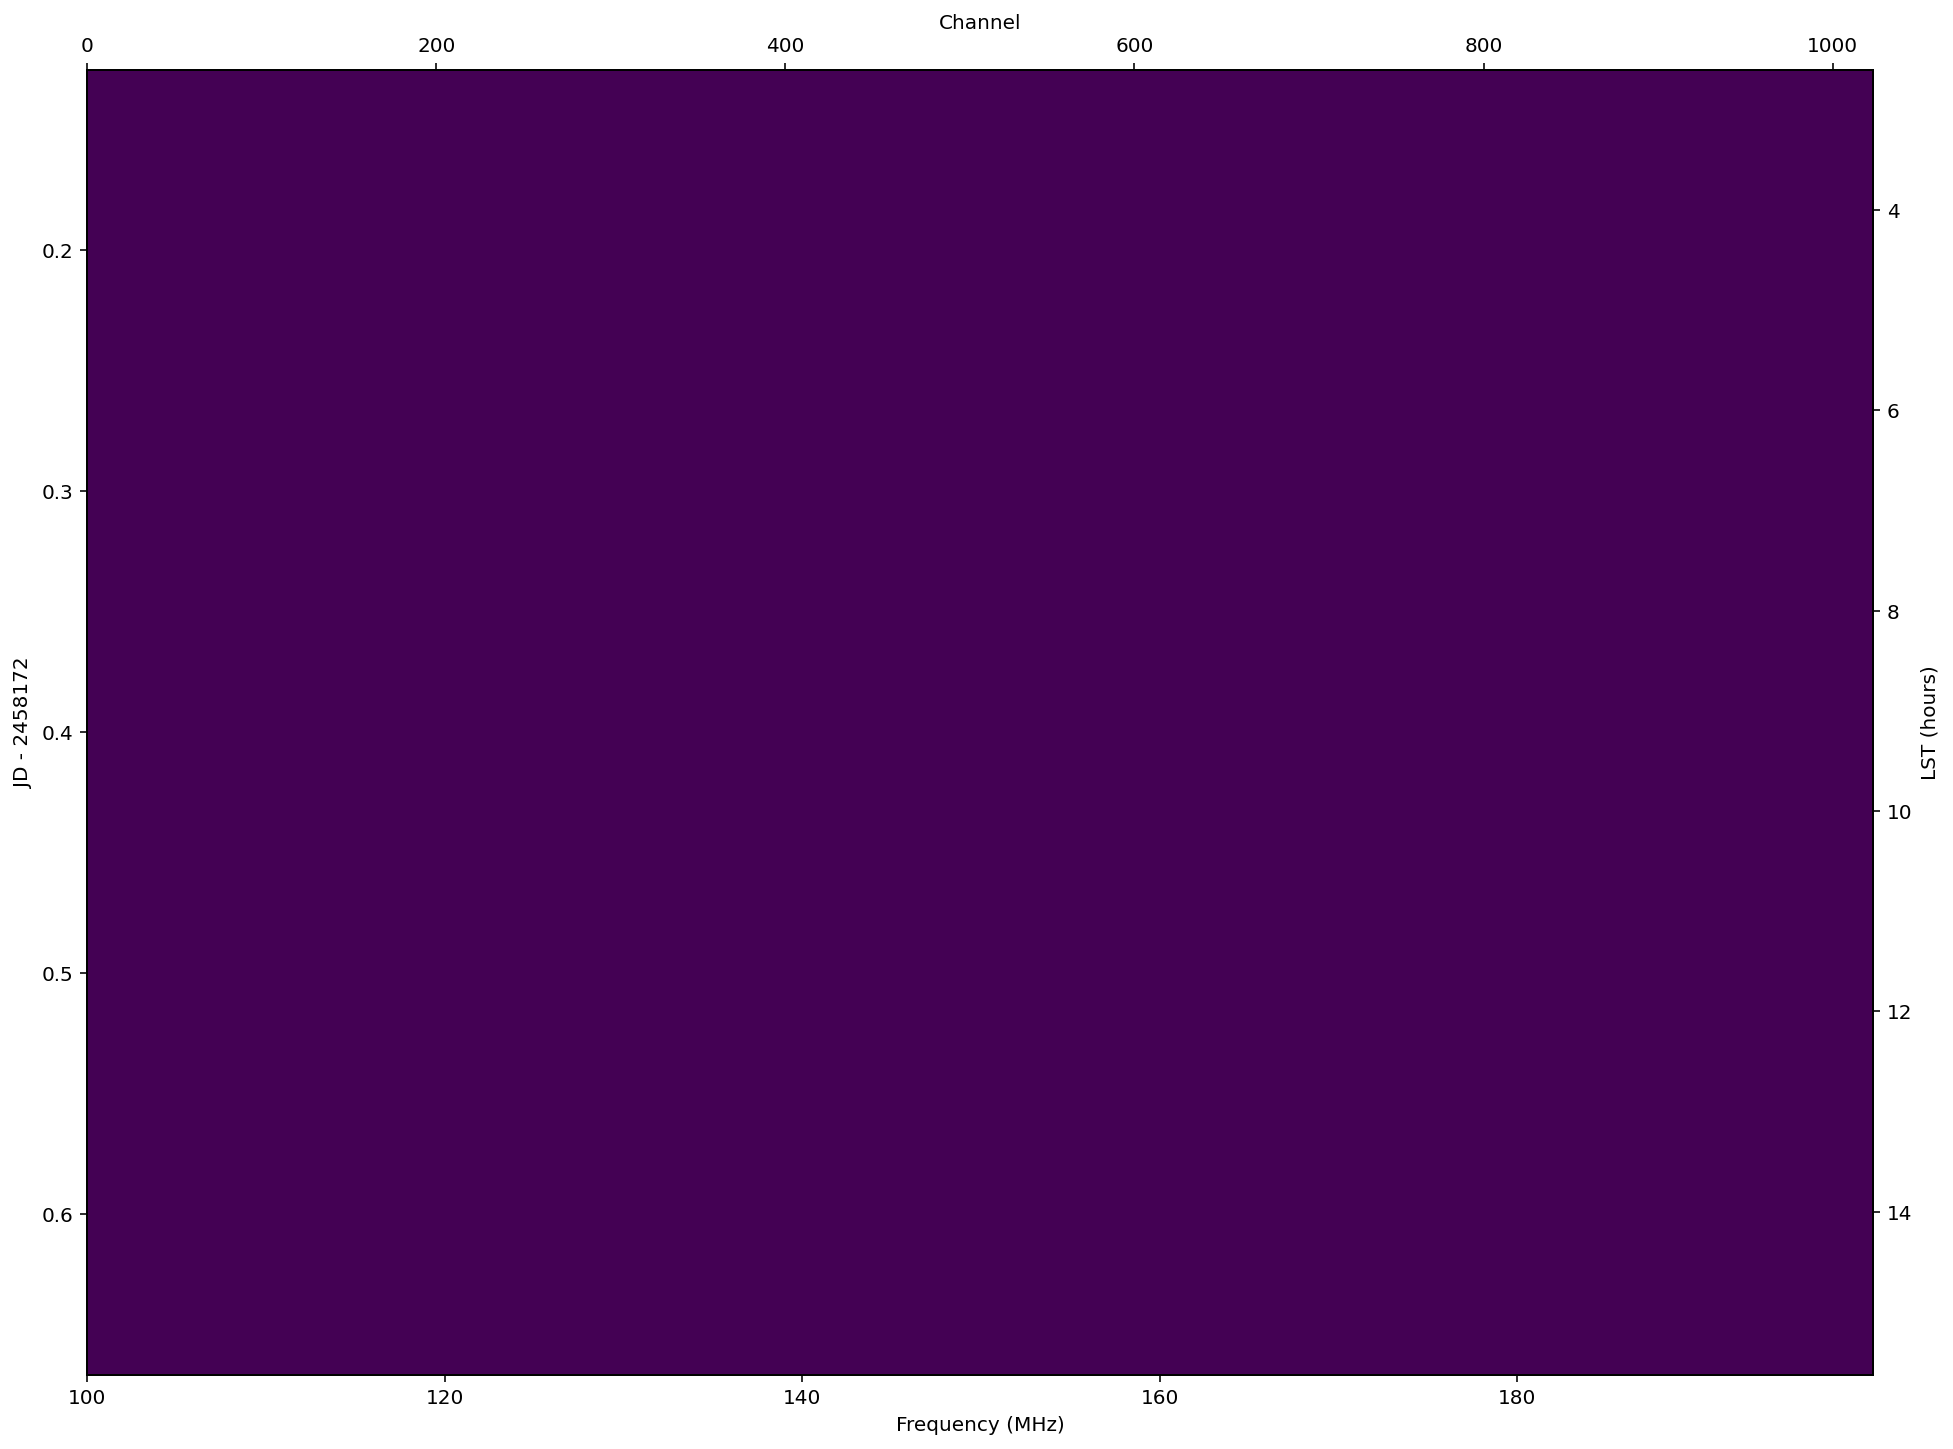

In [5]:
plt.figure(figsize=(16,12))
cax = plt.imshow(uvf.flag_array[:,:,0], aspect='auto', interpolation='nearest',
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

# Figure 1(a): Full day of XRFI flags
Yellow is flagged. Blue is unflagged.

In [6]:
xrfi_dirs = sorted(glob.glob(f'{data_path}/zen.{JD}.?????.xrfi'))
print(f'Found {len(xrfi_dirs)} directories containing XRFI intermediate data products.')
files1 = [glob.glob(f'{d}/*combined_metrics1.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files1)} combined round 1 XRFI metrics files.')
files2 = [glob.glob(f'{d}/*combined_metrics2.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files2)} combined round 2 XRFI metrics files.')
uvf1 = UVFlag(files1)
uvf2 = UVFlag(files2)
uvf2.metric_array = np.where(np.isinf(uvf2.metric_array), uvf1.metric_array,
                             uvf2.metric_array)

Found 73 directories containing XRFI intermediate data products.
Found 73 combined round 1 XRFI metrics files.
Found 73 combined round 2 XRFI metrics files.


default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


Text(0.5, 0, 'Channel')

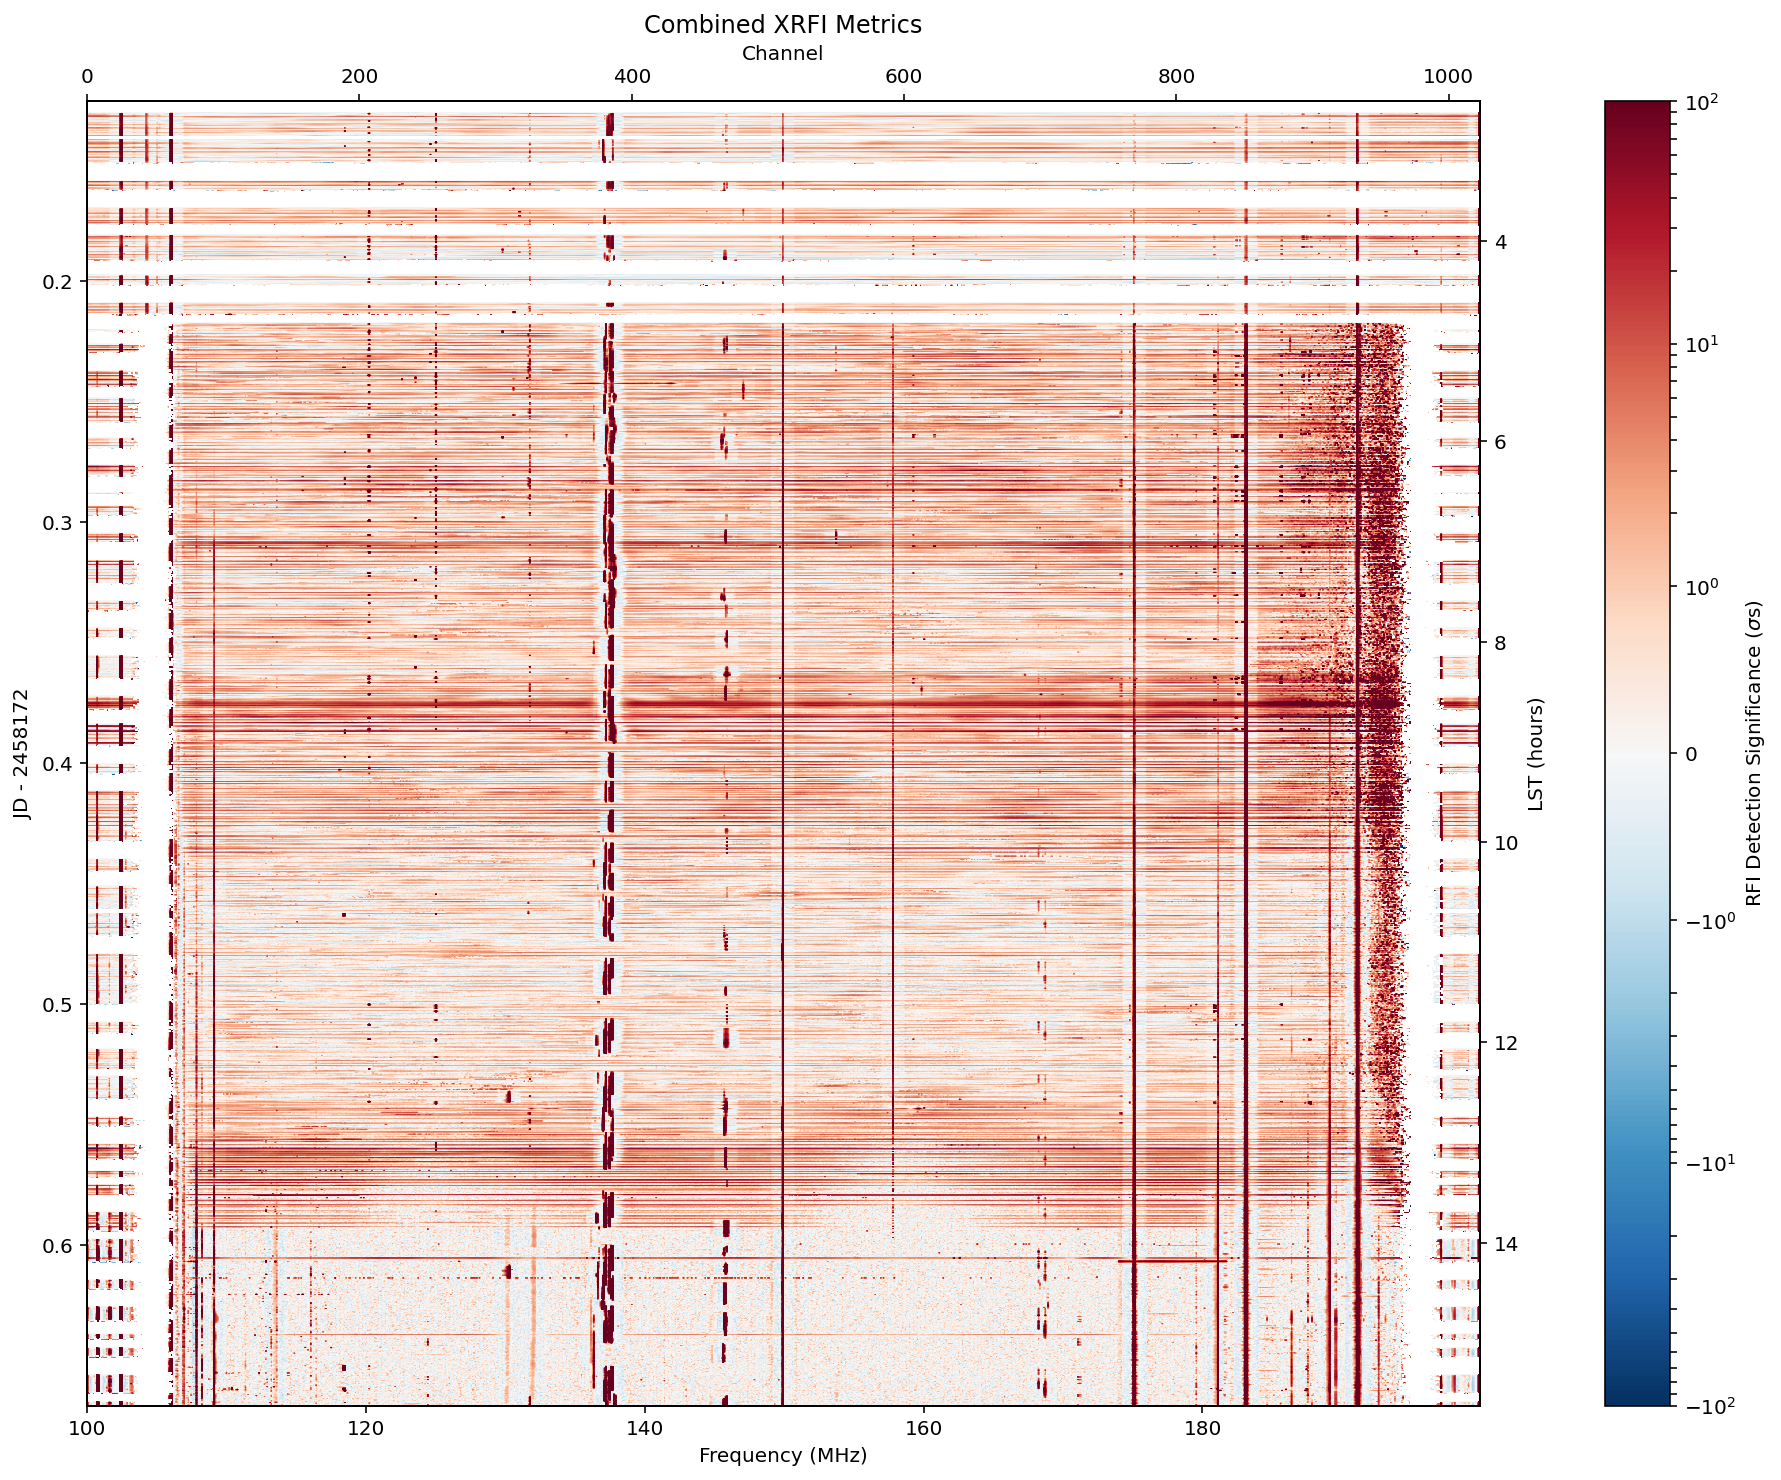

In [7]:
plt.figure(figsize=(16,12))
max_abs = 100
if np.max(uvf2.metric_array) > max_abs:
    extend = 'max'
    if np.min(uvf2.metric_array) < -max_abs:
        extend = 'both'
elif np.min(uvf2.metric_array) < -max_abs:
    extend = 'min'    
else:
    extend = 'neither'

plt.imshow(uvf2.metric_array[:,:,0], aspect='auto', cmap='RdBu_r',
           norm=colors.SymLogNorm(linthresh=1,vmin=-max_abs, vmax=max_abs), 
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.colorbar(pad=.07, extend=extend,
             label='RFI Detection Significance ($\sigma$s)')
plt.title('Combined XRFI Metrics')
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

## Figure 2(a): Combined XRFI Detection Significance
This figure shows round 2 XRFI metrics (mean filter outliers) combined in quadrature. When flagged in round 1 of XRFI, round 1's combined median filter metrics are used instead. 

In [8]:
# Load in the flags from each round of XRFI flagging.
low_level_flag_labels = (
    "abscal_chi_sq_flags1",
    "abscal_chi_sq_flags2",
    "ag_flags1",
    "ag_flags2",
    "apriori_flags",
    "auto_flags1",
    "auto_flags2",
    "ax_flags1",
    "ax_flags2",
    "combined_flags1",
    "combined_flags2",
    "cross_flags1",
    "cross_flags2",
    "flags1",
    "flags2",
    "og_flags1",
    "og_flags2",
    "omnical_chi_sq_flags1",
    "omnical_chi_sq_flags2",
    "ox_flags1",
    "ox_flags2",
    "v_flags1",
    "v_flags2",
)
# Keep the thresholded flags separate for easier analysis.
thresholded_flag_labels = (
    "abscal_chi_sq_renormed_threshold_flags",
    "ag_threshold_flags",
    "auto_threshold_flags",
    "ax_threshold_flags",
    "combined_threshold_flags",
    "cross_threshold_flags",
    "og_threshold_flags",
    "omnical_chi_sq_renormed_threshold_flags",
    "ox_threshold_flags",
    "v_threshold_flags",
    "total_threshold_and_a_priori_flags",
)

low_level_flags = {}
for file_id in low_level_flag_labels:
    flag_files = []
    for xrfi_dir in xrfi_dirs:
        matching_files = glob.glob(os.path.join(xrfi_dir, f"*.{file_id}.h5"))
        if len(matching_files) > 0:
            flag_files.append(matching_files[0])
    if len(flag_files) > 0:
        uvf = UVFlag(flag_files)
        low_level_flags[file_id] = np.squeeze(uvf.flag_array)
    
thresholded_flags = {}
for file_id in thresholded_flag_labels:
    flag_file = f"{data_path}/zen.{JD}.{file_id}.h5"
    if os.path.exists(flag_file):
        uvf = UVFlag(flag_file)
        thresholded_flags[file_id] = np.squeeze(uvf.flag_array)
    
all_flags = dict(**low_level_flags, **thresholded_flags)

In [9]:
label_mapping = {
    f"Round {i}": {
        "Priors": ("apriori_flags", "flags1")[i-1],
        "Autocorrs": f"auto_flags{i}",
        "Crosscorrs": f"cross_flags{i}",
        "Omnical\nVisibilities": f"v_flags{i}",        
        "Omnical\nGains": f"og_flags{i}",
        r"Omnical $\chi^2$": f"ox_flags{i}",
        "Omnical\nGlobal $\chi^2$": f"omnical_chi_sq_flags{i}",
        "Abscal\nGains": f"ag_flags{i}",
        r"Abscal $\chi^2$": f"ax_flags{i}",
        r"Abscal\nGlobal $\chi^2$": f"abscal_chi_sq_flags{i}",        
        "Combined\nMetrics": f"combined_flags{i}",
    } for i in (1,2)
}

label_mapping["Round 3"] = {
    "Priors": "flags2",
    "Autocorrs": "auto_threshold_flags",
    "Crosscorrs": "cross_threshold_flags",    
    "Omnical\nGains": "og_threshold_flags",
    r"Omnical $\chi^2$": "ox_threshold_flags",
    "Omnical\nGlobal $\chi^2$": f"omnical_chi_sq_renormed_threshold_flags",    
    "Omnical\nVisibilities": "v_threshold_flags",
    "Abscal\nGains": "ag_threshold_flags",
    r"Abscal $\chi^2$": "ax_threshold_flags",    
    r"Abscal\nGlobal $\chi^2$": f"abscal_chi_sq_renormed_threshold_flags",        
    "Combined\nMetrics": "combined_threshold_flags",
    'Final\nFlags': "total_threshold_and_a_priori_flags",
}

# remove labels for metrics not used
label_mapping = {rnd: {label: flags for label, flags in labels.items() if flags in all_flags}
                 for rnd, labels in label_mapping.items()}

In [10]:
# Pick easily distinguishable colors
color_palette = (
    '#000000', #black
    '#ffffff', #white
    '#800000', #maroon
    '#808000', #olive
    '#008b8b', #darkcyan
    '#000080', #navy
    '#ff8c00', #darkorange
    '#ffff00', #yellow
    '#00ff00', #lime
    '#0000ff', #blue
    '#ff00ff', #fuchsia
    '#1e90ff', #dodgerblue
    '#98fb98', #palegreen
    '#ff1493', #deeppink
    )

# assign a unique color to a label
label_to_color_map = {"Unflagged": color_palette[0]}
color_index = 1
for mapping in label_mapping.values():
    for label in tuple(mapping.keys()) + ("2+ Separate\nMetrics",):
        if label not in label_to_color_map:
            label_to_color_map[label] = color_palette[color_index]
            color_index += 1

In [11]:
# Figure out which flags are unique to each step and source
unique_flags_by_stage = {}
for round_label, mapping in label_mapping.items():
    unique_flags_by_stage[round_label] = {} 
    # handle prior flags
    prior_flags = low_level_flags[mapping["Priors"]]
    unique_flags_by_stage[round_label]["Priors"] = prior_flags
    # handle all other flag types
    overlap_flags = np.zeros_like(np.squeeze(uvf.flag_array))
    for label, file_id in mapping.items():
        if label in ["Priors", "Final\nFlags", "Combined\nMetrics"]: # skip these, they are special
            continue
        flags = all_flags[file_id]
        unique_flags = flags.copy()
        for other_label, other_file_id in mapping.items():
            if other_label in [label, "Priors", "Final\nFlags", "Combined\nMetrics"]:
                continue
            other_flags = all_flags[other_file_id]
            unique_flags &= ~other_flags
            overlap_region = flags & other_flags & ~prior_flags
            overlap_flags[overlap_region] = True
        unique_flags_by_stage[round_label][label] = unique_flags
    unique_flags_by_stage[round_label]["2+ Separate\nMetrics"] = overlap_flags
    
    # handle combined metrics separately so that it doesn't affect "2+ Separate\nMetrics"
    all_flags_so_far = np.sum(list(unique_flags_by_stage[round_label].values()), axis=0).astype(bool)
    combined_metrics_flags = all_flags[mapping["Combined\nMetrics"]]
    unique_flags_by_stage[round_label]["Combined\nMetrics"] = combined_metrics_flags & ~all_flags_so_far

# Figure out which flags got applied at the very end when the a priori YAML was used
all_other_round_3_flags = np.sum([flags for flags in unique_flags_by_stage['Round 3'].values()], axis=0).astype(bool)
unique_flags_by_stage['Round 3']["Final\nFlags"] = all_flags[label_mapping['Round 3']["Final\nFlags"]] & (~all_other_round_3_flags)

In [12]:
cmap = plt.cm.colors.ListedColormap(list(label_to_color_map.values()))
norm = plt.cm.colors.Normalize(vmin=0, vmax=1)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colored_flags = {}
for round_label, flag_dict in unique_flags_by_stage.items():
    colored_flags[round_label] = np.zeros(np.squeeze(uvf.flag_array).shape)
    for label, flags in flag_dict.items():
        colored_flags[round_label][flags] = list(label_to_color_map.keys()).index(label) / (len(label_to_color_map) - 1)

In [13]:
def plot_flag_evolution(freq_slice):
    fig, axes = plt.subplots(len(colored_flags), figsize=(15, 11 * len(colored_flags)), dpi=300)

    # Figure out the details for which part of the flag arrays to plot.
    tmin, tmax = plot_times[0], plot_times[-1]
    lstmin, lstmax = lsts_hr[0], lsts_hr[-1]
    fmin, fmax = freqs_MHz[freq_slice][::freq_slice.size - 1]
    extent = (fmin, fmax, tmax, tmin)

    # Actually plot the things.
    for ax, (label, flags) in zip(axes, colored_flags.items()):
        ax.set_title(label, fontsize=16)
        ax.imshow(flags[:,freq_slice], aspect="auto", extent=extent, cmap=cmap, vmin=0, vmax=1)
        twinx = ax.twinx()
        twiny = ax.twiny()
        twinx.set_ylim(lstmax, lstmin)
        twiny.set_xlim(freq_slice[0], freq_slice[-1])
        ax.set_xlabel("Frequency (MHz)", fontsize=12)
        ax.set_ylabel(f"JD - {JD}", fontsize=12)
        twinx.set_ylabel("LST (hour)", fontsize=12)
        twiny.set_xlabel("Channel", fontsize=12)

    fig.tight_layout()
    for ax in axes.ravel():
        cbar = fig.colorbar(smap, ax=ax, orientation="horizontal", pad=0.1)
        cbar.set_ticks(np.linspace(0, 1, 2 * len(cmap.colors) + 1)[1::2])
        cbar.set_ticklabels(list(label_to_color_map.keys()))    

In [14]:
# Plot flags in the low-band.
if np.any(freqs_MHz < 100):
    freq_slice = np.argwhere(freqs_MHz < 100).flatten()  # Low-band, pre-FM
    plot_flag_evolution(freq_slice)

## Figure 3: Flag Evolution in the Low Band
This figure delineates which steps different flags are introduced in, but does not make a distinction between sources when multiple flagging routines flag the same region of the waterfall. The plot shows flags for frequencies below the FM band, for the entire night. The top plot shows the flags for the first round of flagging (median filter), where the prior flags are the apriori flags; the middle plot shows the flags for the second round of flagging (mean filter), where the prior flags are the combined flags from the first round of flagging (plus extra flags based on the metrics added in quadrature); the bottom plot shows the flags for the final round of flagging (thresholding), where the prior flags are the combined flags from round 2 (plus extra flags based on the metrics added in quadrature). After threshold flagging, the "final flags" also include any apriori flags from the YAML files. *Note: for H1C data, this plot will be skipped.*

In [15]:
# Plot flags in the mid-band.
freq_slice = np.argwhere(np.logical_and(freqs_MHz >= 100, freqs_MHz < 200)).flatten()
plot_flag_evolution(freq_slice)

## Figure 4: Flag Evolution in the Mid-Band
This figure delineates which steps different flags are introduced in, but does not make a distinction between sources when multiple flagging routines flag the same region of the waterfall. The plot shows flags for frequencies between the FM band and the analog TV band, for the entire night. The top plot shows the flags for the first round of flagging (median filter), where the prior flags are the apriori flags; the middle plot shows the flags for the second round of flagging (mean filter), where the prior flags are the combined flags from the first round of flagging (plus extra flags based on the metrics added in quadrature); the bottom plot shows the flags for the final round of flagging (thresholding), where the prior flags are the combined flags from round 2 (plus extra flags based on the metrics added in quadrature).  After threshold flagging, the "final flags" also include any apriori flags from the YAML files. 

In [16]:
# Calculate occupancies for different important sets of flags.
label_mapping = {
    "A Priori": "apriori_flags",
    "Median Filter": "flags1",
    "Mean Filter": "flags2",
    "Thresholding": "total_threshold_and_a_priori_flags",
}
occupancies = {}
for axis, axis_label in enumerate(("Frequency", "Time")):
    occupancies[axis_label] = {}
    for flag_label, flag_id in label_mapping.items():
        flags = all_flags[flag_id]
        occupancies[axis_label][flag_label] = flags.mean(axis=(1-axis))

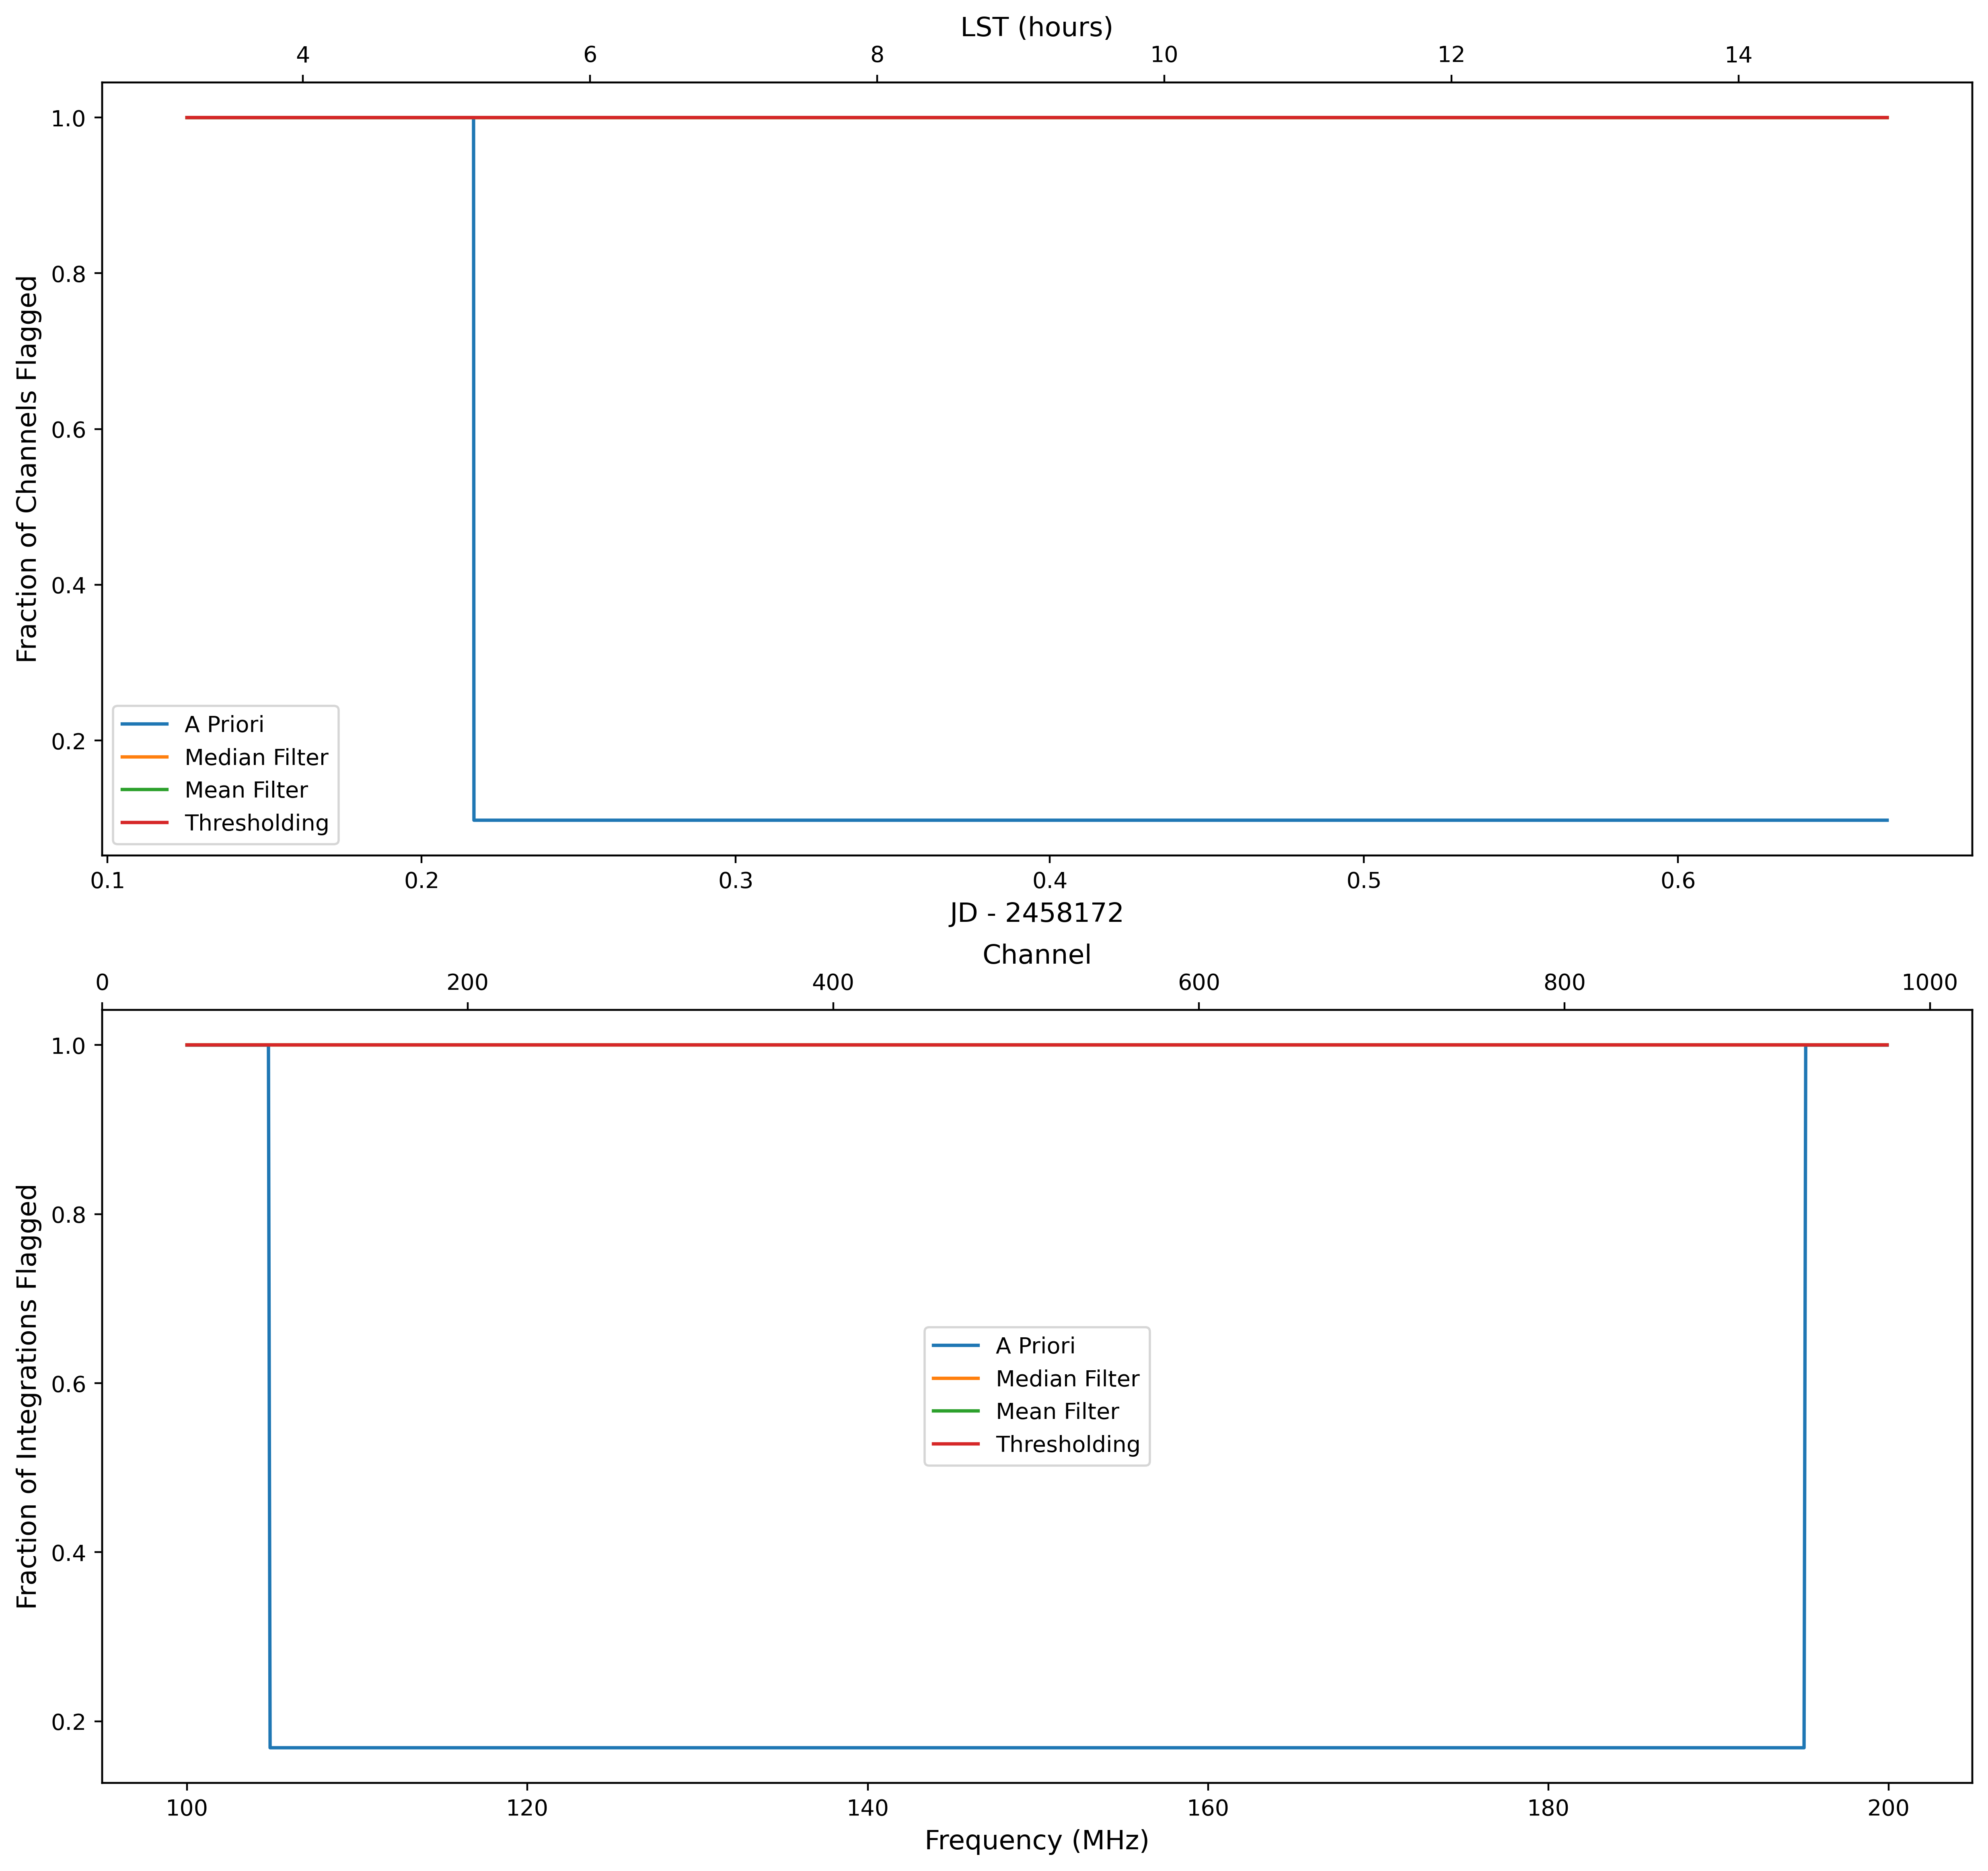

In [17]:
fig, axes = plt.subplots(2, figsize=(15,14), dpi=200)
for i, items in enumerate(zip(axes.ravel(), occupancies.items())):
    ax, (occupancy_axis, flag_dict) = items
    xvalues = (plot_times, freqs_MHz)[i]
    alt_xvalues = (lsts_hr, chans)[i]
    xlabel = (f"JD - {JD}", "Frequency (MHz)")[i]
    ylabel = (
        "Fraction of Channels Flagged",
        "Fraction of Integrations Flagged"
    )[i]
    alt_xlabel = ("LST (hours)", "Channel")[i]
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    for flag_label, occupancy in flag_dict.items():
        ax.plot(xvalues, occupancy, label=flag_label)
    twin_ax = ax.twiny()
    twin_ax.set_xlim(alt_xvalues[0], alt_xvalues[-1])
    twin_ax.set_xlabel(alt_xlabel, fontsize=12)
    ax.legend()

## Figure 5: Flagging Occupancies
These plots show the flagging occupancies for the Round 0 Flags (Apriori), Round 1 Flags (Median Filter), Round 2 Flags (Mean Filter), and Round 3 Flags (Thresholding). The top plot shows the fraction of channels flagged at each integration for each set of flags, and the bottom plot shows the fraction of integrations flagged as a function of frequency.

# Metadata

In [18]:
from hera_qm import version
print(version.construct_version_info())

{'version': '1.0', 'git_origin': 'git@github.com:HERA-Team/hera_qm.git', 'git_hash': 'a15c511f7e0fc30602257c9eb5ff761bc83ef6a5', 'git_description': 'v1.1-313-ga15c511', 'git_branch': 'master'}
